# Filtering All Tweets by Topic
***

**Project**: Master Thesis for MSc in Data Science for Decision Making

**Institution**: Barcelona School of Economics, Class of 2022

**Students**: Andrés Couble, Kalliope Stasssinos, Mathias Schindler

**Notebook Author**: Andrés Couble

**Submission Date**: June 26, 2022

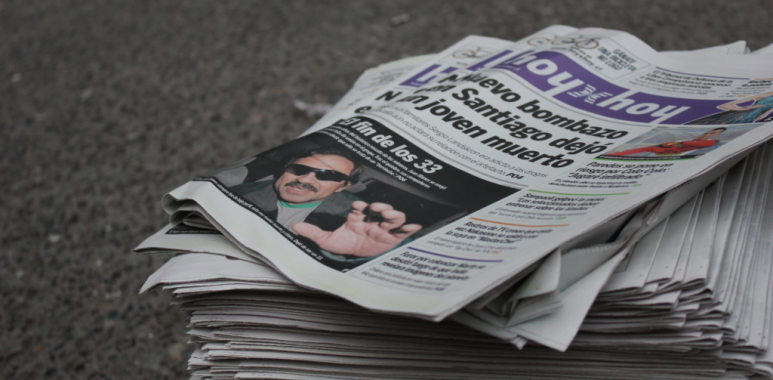

**Execution Time**
<br>
MacBook Pro (2020-model) with a 2 GHz Quad-Core Intel Core i5 and 16 GB RAM runs this notebook in 4 mins and 46 secs. (See also the very last code cell which prints total execution time of notebook.)

### Preamble

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import random
import string
import pickle

import json
import emoji
import unidecode

from datetime import datetime, timedelta
from collections import Counter
from operator import itemgetter
from advertools import extract_emoji

from twarc.expansions import ensure_flattened
from twarc_csv import DataFrameConverter
from twarc_csv import dataframe_converter
from twarc_csv import CSVConverter, DataFrameConverter

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer

**Manual Input**: Set the path.

In [ ]:
path='C:/Users/acoub/OneDrive/Desktop/DSDM/Thesis/ChileGov/methodology_blank'
sep='/'

In [ ]:
path_scripts = path+sep+'udpate_topic'
path_data= path+sep+'data'

In [ ]:
notebook_start = datetime.now() #Start timer for entire notebook

In [ ]:
# Setting: Show all columns in pd.DataFrame
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.options.display.max_colwidth = 200

# Resets
#pd.reset_option('display.max_colwidth')
#pd.reset_option('display.max_rows')

# Load Data and Explore

In [ ]:
converter = DataFrameConverter()
data = []
with open(path_data+sep+"updated_final_corpus.json") as f:
    for line in f:
        data.append(json.loads(line))
df = converter.process(data)


In [ ]:
df.head()

In [ ]:
df.shape

# Numbers of authors

In [ ]:
authors = df[['author.id','author.username']]
authors = authors.drop_duplicates()
print(authors.shape)

# Random Locations and Description

Test that we have tweets from Chile

In [ ]:
number_of_tweets = 20
for i in range(0,number_of_tweets):
    indexes = list(df.index) 
    a = random.choice(indexes)
    print(df['author.location'][a])
    print(df['author.description'][a])
    print("")
    indexes.remove(a)

# Most Popular Hashtags

In [ ]:
def hash_retrieve(df):
    """
    df : dataframe of tweets
    Description: 
        The function takes as an object a df of tweets obtained via twarc and 
        returns a generator object.
    
    """

    for line, id in zip(df['entities.hashtags'], df['id']):
        if pd.isna(line):
            continue
        line = line.strip()
        data = json.loads(line)
        for hashtag in ensure_flattened(data):
            yield [hashtag['tag'], id]

hashtags_df = pd.DataFrame(list(hash_retrieve(df)),
                 columns = ['tweet_hashtags', 'id'])


hashtags_df = hashtags_df.groupby('id')['tweet_hashtags'].apply(lambda x: ','.join(x))
df = df.merge(hashtags_df, how = 'left', left_on = 'id', right_on = 'id')
df['tweet_hashtags'] = df['tweet_hashtags'].str.lower()

In [ ]:
hasht = []
for i in df.index:
    try:
        hasht.append(df['tweet_hashtags'][i].split(","))
    except:
        hasht.append([])
    
    
df['list_hashtags'] = hasht

hashtags = []
for i in df.index:
    hashtags += df['list_hashtags'][i]

**Manual revision:** This is the list of 200 most common hashtags in the final data set.

In [ ]:
count = Counter(hashtags)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = count.most_common(200)
  
print(most_occur)

# Most Popular Words

In [ ]:
stopwords_eng =stopwords.words("english")
stopwords_es = stopwords.words("spanish")
stopwords_all = stopwords_eng + stopwords_es

def cleanTweets(s,remove_hash):
    #Function to clean tweets, for now i am keeping emojis and hashtags. Alternative version
    if type(s) == np.float64:
        return ""
    #Demojize text
#    s=emoji.demojize(s,delimiters=("", " "))
    
    #Remove new lines, etc.
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    s = s.replace("\n", " ")
    s = s.replace("\\n", " ")
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    s= emoji_pattern.sub(r'', s)
    
    
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    #s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    #Remove punctuation    
    s = re.sub('[()!?]', ' ', s)
    s = re.sub('\[.*?\]',' ', s)
    s = re.sub('\[,*?\]',' ', s)
    # custom removals
    #s = re.sub(r'@[A-Za-z0-9_]+', "", s) # replace mentions
    s = re.sub(r':[^:]+','[emoji]',s) # remove demojized text
    #s = re.sub(r'[0-9]','',s)# remove digits
    
    s = s.translate(str.maketrans('', '', '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'))
    
    s = s.lower()
    if remove_hash == True:
        s = re.sub(r'#[A-Za-z0-9_]+', "", s)
    
    #Remove stopwords
    s = ' '.join([word for word in s.split() if word not in stopwords_all])
    
    return str(s)


In [ ]:
df['cleaned_text'] = [cleanTweets(text,False) for text in df['text']]
df['cleaned_text'] = df['cleaned_text'].apply(unidecode.unidecode)

In [ ]:
df['cleaned_text']=df['cleaned_text'].fillna("")
string = " ".join(list(df['cleaned_text']))

**Manual revision:** This is the list of 200 most common words in the final data set.

In [ ]:
split_it = string.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(200)
  
print(most_occur)

## Review Random Tweets from Specific Hashtags

**Manual revision:** For an specific hashtag writted where now is the word "example", you can review a random sample of 20 tweets that contain this hashtag.

In [ ]:
hashtag = 'chileestadeluto'
df_hash = df.dropna(subset = ['tweet_hashtags'])
df_hash = df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
number_of_tweets = 20
print(df_hash.shape)
indexes = list(df_hash.index)
for i in range(0, number_of_tweets): 
    a = random.choice(indexes)
    print(df_hash['text'][a])
    print("")
    indexes.remove(a)

## Review Random Tweets from Specific Words

**Manual revision:** For an specific word writted where now is the word "example", you can review a random sample of 20 tweets that contain this hashtag.

In [ ]:
word = 'boric'
regex = '(?:^|\W)' + word + '(?:$|\W)'
df_word = df.dropna(subset = ['text'])
df_word = df_word[df_word.text.str.contains(regex)]
number_of_tweets = 20
print(df_word.shape)
indexes = list(df_word.index)
for i in range(0,number_of_tweets): 
    a = random.choice(indexes)
    print(df_word['text'][a])
    print("")
    indexes.remove(a)

# Remove Tweets with Specific Hashtags

**Manual input:** Considering the previous revision, put in a list hashtags that you want to remove from the data set. All the tweets that contain this hashtags will be deleted. You don't have to put the # before the hashtag, you have to write all the characters in lowercase and not include accents or special characters like ñ.

In [ ]:
list_to_remove = []

In [ ]:
for hashtag in list_to_remove:
    df_hash = df.dropna(subset = ['tweet_hashtags'])
    df_hash = df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
    df_hash['Remove'] = True
    df_remove = df_hash[['id','Remove']]
    df = df.merge(df_remove, how = 'left', on = 'id')
    df = df.drop(df[df.Remove == True].index)
    df = df.drop(['Remove'], axis = 1)

In [ ]:
df.shape

# Remove Tweets with Specific Words

**Manual input:** Considering the previous revision, put in a list words that you want to remove from the data set. All the tweets that contain this words will be deleted. You have to write all the characters in lowercase and not include accents or special characters like ñ.

In [ ]:
list_to_remove = []
for words in list_to_remove:
    regex = '(?:^|\W)' + word + '(?:$|\W)'
    df_word = df.dropna(subset = ['text'])
    df_word = df_word[df_word.text.str.contains(regex)]
    df_word['Remove'] = True
    df_remove = df_word[['id','Remove']]
    df = df.merge(df_remove, how = 'left', on = 'id')
    df = df.drop(df[df.Remove == True].index)
    df = df.drop(['Remove'], axis = 1)

In [ ]:
print("Final number of tweets: " + str(df.shape[0]))
print("Final number of authors: " + str(df[['author.id','author.username']].drop_duplicates().shape[0]))

In [ ]:
authors = df[['author.id','author.username']]
authors = authors.drop_duplicates()
print(authors.shape)

# Review Random Sample

**Manual revision:** Review a random sample of tweets from the data set, to be ensure that contain mainly useful tweets.

In [ ]:
number_of_tweets = 200
indexes = list(df.index) 
for i in range(0, number_of_tweets):
    a = random.choice(indexes)
    print(df['text'][a])
    print("")
    indexes.remove(a)

## Keeping only the relevant columns to save space.

In [ ]:
cols_to_keep = ['id','text','conversation_id','author.id','author.description','author.location','author.username','author.name','entities.hashtags','author.public_metrics.followers_count','author.verified','public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'public_metrics.retweet_count','cleaned_text','tweet_hashtags','created_at', 'list_hashtags']

# Export

In [ ]:
df=df[cols_to_keep]
filename = path_data+sep+'final_data_set_update.sav'
pickle.dump((df), open(filename, 'wb'))

In [ ]:
#Print runtime
print('Runtime for entire notebook:', datetime.now() - notebook_start)